# An interactive SMASH density map


## Visualization
In this notebook, we will use Datashader and Bokeh to make an interactive density map of SMASH all-sky photometry.

## Known issues

With this prototype notebook, there is not yet a way to clearly identify the field numbers or coordinates in the all sky plot.

### Initialization

We need modules from the Bokeh library, Datashader, NumPy, Pandas, and pyproj, as well as the Data Lab modules to connect to the database.

In [1]:
print "Start"
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage
from pyproj import Proj
import numpy as np

from cStringIO import StringIO
from dl import authClient
from dl import queryClient 

import pandas as pd
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf


# Get the security token for the datalab demo user
token = authClient.login('anonymous')
print "Got token",token

Start
Got token anonymous.0.0.anon_access


### Querying the SMASH DR1 catalog

We will query the entire SMASH catalog, but with a somewhat restricted sharp, magnitude, and color range, as well as a limit on the depth flag, to limit the number of objects returned.

In [2]:
%%time
depth = 1                   # minimum depth 
raname = 'ra'
decname = 'dec'
mags = 'gmag,rmag'
dbase='smash_dr1.object'

# Create the query string.
query = ('select fieldid,'+raname+','+decname+','+mags+',depthflag from '+dbase+ \
        ' where (depthflag > %d and ' + \
        ' (abs(sharp) < 0.5) and ' + \
        ' (gmag is not null) and (rmag is not null) and' + \
        ' (gmag between 18 and 24) and ' + \
        ' ((gmag-rmag) between -1 and 3))') % \
           (depth)
        
print "Your query is:", query
print "Making query"

# Call the Query Manager Service    
response = queryClient.query(token, adql = query, fmt = 'csv')
df = pd.read_csv(StringIO(response))

print len(df), "objects found."

Your query is: select fieldid,ra,dec,gmag,rmag,depthflag from smash_dr1.object where (depthflag > 1 and  (abs(sharp) < 0.5) and  (gmag is not null) and (rmag is not null) and (gmag between 18 and 24) and  ((gmag-rmag) between -1 and 3))
Making query
5445976 objects found.
CPU times: user 4.27 s, sys: 875 ms, total: 5.15 s
Wall time: 1min 1s


### Data munging

We'll use our Pandas DataFrame to add a blue/red category for objects with colors bluer/redder than g-r=0.4, and use pyproj to project the coordinates to a Goode Homolosine projection.

In [3]:
p1=Proj(proj='goode')
df["g_r"]=df["gmag"]-df["rmag"]
lat=np.array(df["dec"])
lon=np.array(df["ra"]-180)
x,y=p1(lon,lat)
df["x"]=x/1e6
df["y"]=y/1e6

colthresh=0.4  #g-r>0.4 == Red
df["Class"]='Blue'
df.loc[df["g_r"]>colthresh,"Class"]='Red'
df["Class"]=df["Class"].astype('category')
df.tail()

,fieldid,ra,dec,gmag,rmag,depthflag,g_r,x,y,Class
5445971,20,35.705222,-66.790792,23.9966,23.9193,2,0.0773,-8.034689,-7.163028,Blue
5445972,20,35.705774,-66.789700,23.8267,23.5245,2,0.3022,-8.034889,-7.162933,Blue
5445973,20,35.696410,-66.784513,23.4505,23.3245,2,0.1260,-8.036501,-7.162478,Blue
5445974,20,35.699459,-66.783013,23.4188,23.2759,2,0.1429,-8.036647,-7.162346,Blue
5445975,20,35.669377,-66.779954,23.6111,23.0070,2,0.6041,-8.038966,-7.162078,Red


### A density map for Field 169

Datashader creates a canvas from the two-dimensional data that you select, aggregates the data, and then uses a transfer function to map the aggregated data onto the canvas.  In one fell swoop, limited to Field 169:

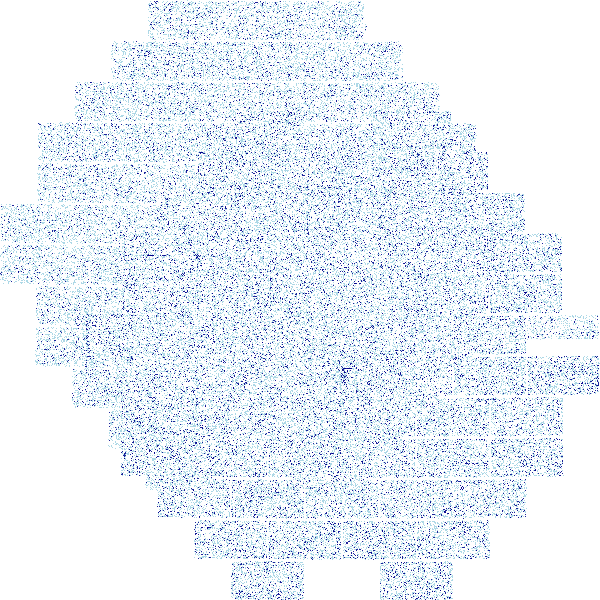

In [4]:
df2=df[df["fieldid"]==169]
tf.shade(ds.Canvas().points(df2,'ra','dec'))

### Field 169 density map colored by category

Here we break down Datashader's steps and a couple of more parameters, such as specifying a log stretch in the transfer function and use our Blue/Red category in making the aggregate.  We'll also spread the points out a bit to make theam easier to see.  There are many more parameters decribed in the Datashader documentation.

/dl1/sw/anaconda2/lib/python2.7/site-packages/datashader/transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
/dl1/sw/anaconda2/lib/python2.7/site-packages/datashader/transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
/dl1/sw/anaconda2/lib/python2.7/site-packages/datashader/transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


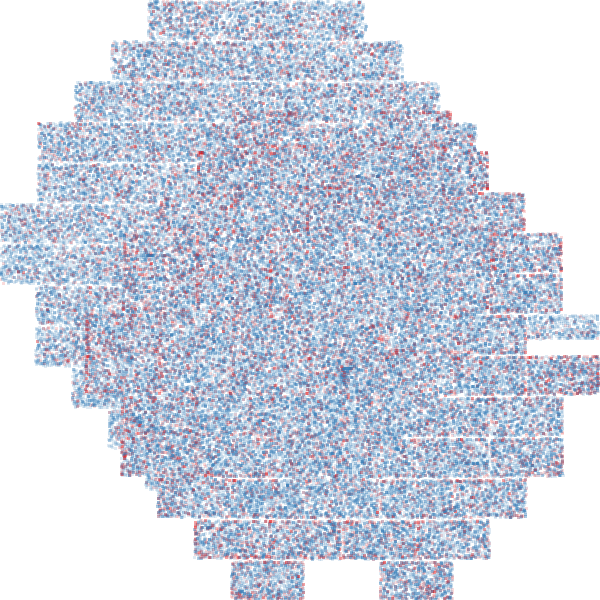

In [5]:
canvas = ds.Canvas(plot_width=600, plot_height=600)
agg  = canvas.points(df2, 'ra', 'dec', ds.count_cat("Class"))
img = tf.shade(agg, how='log',alpha=255)
tf.spread(img,px=1)

### The interactive all-sky density map

We can combine Datashader with Bokeh's interactive plotting to make a dynamic density map of our entire SMASH query result.  The code below makes use of Datashader's dynamic spread transfer function, which gives the map variable resolution as a function of zoom level.  Try the Wheel Zoom function or Box Zoom to zoom in on a particular field.  The field at (-4,-7.5) has a couple of background galaxy clusters in it.

In [6]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,box_zoom,reset',x_range=(-10,10), y_range=(-10,0))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat("Class"))
    img = tf.shade(agg, how='log')
    return tf.dynspread(img, how='add',threshold=0.1)

InteractiveImage(p, image_callback)

Loading BokehJS ...